## learning-AI101 : HARTH classification (DL)
### The Human Activity Recognition Trondheim (HARTH)를 Dense layer struction을 통한 DNN, CNN 1D, U-net을 통한 encoder-decoder 방식의 classification

<br>

- **임규연 (lky473736)**
- 2024.08.04., 2024.08.23. ~ 2024.08.25.에 문서 작성
- **dataset** : https://archive.ics.uci.edu/dataset/779/harth
- **data abstract** : The Human Activity Recognition Trondheim (HARTH) dataset is a professionally-annotated dataset containing 22 subjects wearing two 3-axial accelerometers for around 2 hours in a free-living setting. The sensors were attached to the right thigh and lower back. The professional recordings and annotations provide a promising benchmark dataset for researchers to develop innovative machine learning approaches for precise HAR in free living.

------



## <span id='dl'><mark>DL</mark></span>
    
deep learning으로 HARTH을 classification한다. 목차는 아래와 같다.

- **1. 데이터 load and preprocessing**
- **2. ANN (fully connected)**
- **3. DNN**
- **4. CNN 1D**
- **5. U-net**


In [1]:
# 라이브러리 import

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

2024-08-29 00:38:30.078789: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


------

### 1. 데이터 load 및 preprocessing
- 데이터 로드 및 필요한 정보, 기초통계량을 get한다.
- 결측치 제거, outlier 제거 등의 데이터 전처리를 수행한다.
- **자세한 EDA는 ./ML_classification_HARTH를 참고할 것**

In [2]:
# 파일 중 S006.csv를 열어서 header를 확인한다.

df_sample = pd.read_csv('../../data/harth/S006.csv')
df_sample.columns

Index(['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y',
       'thigh_z', 'label'],
      dtype='object')

In [3]:
# records 병합

import glob

directory_path = '../../data/harth'

# 모든 CSV 파일의 경로를 가져오기
all_files = glob.glob(directory_path + "/*.csv")

print (all_files)

# 데이터프레임을 담을 빈 리스트 생성
df_list = []

# 모든 파일을 순회하며 데이터프레임에 추가
for filename in all_files :
    df = pd.read_csv(filename)  
    df_list.append(df) 

merged_df = pd.concat(df_list, ignore_index=True) # 병합 (header는 ignore)
df = merged_df

df.head()

['../../data/harth/S016.csv', '../../data/harth/S017.csv', '../../data/harth/S029.csv', '../../data/harth/S015.csv', '../../data/harth/S014.csv', '../../data/harth/S028.csv', '../../data/harth/S010.csv', '../../data/harth/S013.csv', '../../data/harth/S012.csv', '../../data/harth/S006.csv', '../../data/harth/S023.csv', '../../data/harth/S022.csv', '../../data/harth/S008.csv', '../../data/harth/S020.csv', '../../data/harth/S021.csv', '../../data/harth/S009.csv', '../../data/harth/S025.csv', '../../data/harth/S019.csv', '../../data/harth/S018.csv', '../../data/harth/S024.csv', '../../data/harth/S026.csv', '../../data/harth/S027.csv']


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,index,Unnamed: 0
0,2019-01-12 00:00:00.000,-0.982201,-0.031251,0.178300,-0.935149,0.006160,-0.358898,6,NaN,NaN
1,2019-01-12 00:00:00.020,-0.973421,-0.042747,0.190618,-0.934986,0.040489,-0.366376,6,NaN,NaN
2,2019-01-12 00:00:00.040,-0.977409,-0.033531,0.185584,-0.939761,0.028617,-0.370106,6,NaN,NaN
3,2019-01-12 00:00:00.060,-0.974620,-0.034506,0.188868,-0.939667,0.036060,-0.369624,6,NaN,NaN
4,2019-01-12 00:00:00.080,-0.976828,-0.041577,0.186524,-0.946145,0.030512,-0.363411,6,NaN,NaN


In [4]:
# timestamp, index 삭제, unnamed 삭제

try : 
    del df['timestamp']
    del df['index']
except : 
    pass

df.drop(['Unnamed: 0'], axis = 1, inplace = True)
print ("현재 attribute : ", df.columns)

현재 attribute :  Index(['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label'], dtype='object')


In [5]:
# df의 크기 및 info
print("df 크기 : ", df.shape)
df.info()

df 크기 :  (6461328, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6461328 entries, 0 to 6461327
Data columns (total 7 columns):
 #   Column   Dtype  
---  ------   -----  
 0   back_x   float64
 1   back_y   float64
 2   back_z   float64
 3   thigh_x  float64
 4   thigh_y  float64
 5   thigh_z  float64
 6   label    int64  
dtypes: float64(6), int64(1)
memory usage: 345.1 MB


In [6]:
# df의 기본적인 정보 및 기초통계량

df.describe()

,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
count,6.461328e+06,6.461328e+06,6.461328e+06,6.461328e+06,6.461328e+06,6.461328e+06,6.461328e+06
mean,-8.849574e-01,-1.326128e-02,-1.693779e-01,-5.948883e-01,2.087665e-02,3.749160e-01,6.783833e+00
std,3.775916e-01,2.311709e-01,3.647385e-01,6.263466e-01,3.884511e-01,7.360983e-01,1.143238e+01
min,-8.000000e+00,-4.307617e+00,-6.574463e+00,-8.000000e+00,-7.997314e+00,-8.000000e+00,1.000000e+00
25%,-1.002393e+00,-8.312914e-02,-3.720700e-01,-9.742110e-01,-1.000873e-01,-1.557138e-01,3.000000e+00
50%,-9.748998e-01,2.593677e-03,-1.374510e-01,-4.217309e-01,3.262909e-02,7.004390e-01,7.000000e+00
75%,-8.123032e-01,7.251000e-02,4.647321e-02,-1.678755e-01,1.549512e-01,9.486747e-01,7.000000e+00
max,2.291708e+00,6.491943e+00,4.909483e+00,7.999756e+00,7.999756e+00,8.406235e+00,1.400000e+02


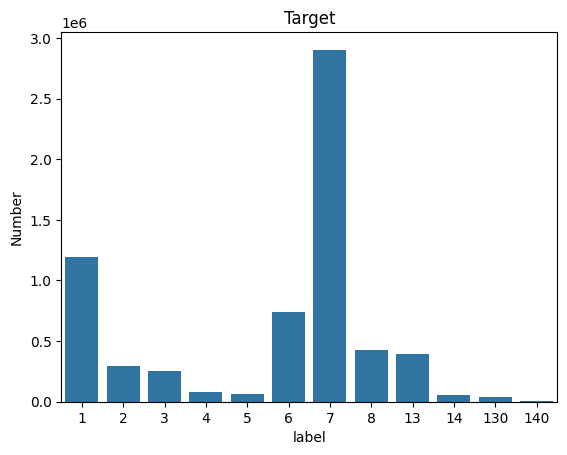

In [7]:
# seaborn countplot을 통한 각 레이블 도수 확인

sns.countplot (data=df, x='label')
plt.xlabel ("label")
plt.ylabel ("Number")
plt.title ("Target")
plt.show()

In [8]:
# target의 class 도수를 확인 (숫자로)

df['label'].value_counts()

label
7      2902703
1      1197155
6       743480
8       428898
13      393963
2       291356
3       254839
4        76217
5        67253
14       55814
130      41785
140       7865
Name: count, dtype: int64

위 target을 countplot으로 표현한 figure을 보았을 때, 알 수 있는 사실은 다음과 같다.
- **7**이 압도적인데, 7은 **sitting**, 즉 앉아 있는 것을 의미한다.
- 각 target의 번호를 맞추어주어야 할 것 같다. 13을 9로, 14를 10으로, 130을 11로, 140을 12로 수정한다.
- 또한, 전체 label의 구성을 바꾸어주어야 한다.
    - **sparse_crossentropy는 클래스를 0부터 인식한다.** 따라서, 현재 1~12로 class를 구성하고 output layer의 node 수를 12로 설정하면 **INVALID_ARGUMENT** 에러가 날 것이다.
    - 따라서, 각 class를 1-based가 아닌, **0-based**로 수정한다.

In [9]:
# # iterrows를 사용하여 각 행에 접근

# for index, row in df.iterrows() :
#     compo_label = df.at[index, 'label']
    
#     if compo_label == 13 :
#         df.at[index, 'label'] = 9
        
#     elif compo_label == 14 : 
#         df.at[index, 'label'] = 10
        
#     elif compo_label == 130 : 
#         df.at[index, 'label'] = 11
        
#     elif compo_label == 140 : 
#         df.at[index, 'label'] = 12

df['label'] = df['label'].replace({13: 9, 14: 10, 130: 11, 140: 12})

for_0_based = dict()
for i in range (12) : 
    for_0_based[i+1] = i
    
df['label'] = df['label'].replace(for_0_based)

# label 열의 고유값을 출력
print (df['label'].unique())


[ 5  2  0  6  1  7  4  3  8 10  9 11]


In [10]:
# input과 target으로 split

harth_input = df[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']].to_numpy() 
harth_target = df['label'].to_numpy()

In [11]:
# X_train, y_train, X_test, y_test으로 train set, test set 각각 8:2로 split
# 또한, X_train, y_train, X_val, y_val로 train set, validation set 각각 8:2로 split

X_train, X_test, y_train, y_test = train_test_split(harth_input, harth_target, 
                                                   stratify=harth_target, 
                                                   test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                        test_size=0.2, 
                                                        stratify=y_train)

In [12]:
# StandardScaler을 통한 정규화 진행

ss_transformer = StandardScaler()

ss_transformer.fit(X_train)

X_train_scaled = ss_transformer.transform(X_train)
X_test_scaled = ss_transformer.transform(X_test)
X_val_scaled = ss_transformer.transform(X_val)

In [13]:
# feature 늘리기 (추후 사용)

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()
poly.fit(X_train)

X_train_poly = poly.transform (X_train)
X_test_poly = poly.transform (X_test)
X_val_poly = poly.transform (X_val)

print (f"shape | X_train_poly : {X_train_poly.shape}, X_test_poly : {X_test_poly.shape}")
print (f"poly | {poly.get_feature_names_out()}")

ss_transformer = StandardScaler()

ss_transformer.fit(X_train_poly)

X_train_poly_scaled = ss_transformer.transform(X_train_poly)
X_test_poly_scaled = ss_transformer.transform(X_test_poly)
X_val_poly_scaled = ss_transformer.transform(X_val_poly)

shape | X_train_poly : (4135249, 28), X_test_poly : (1292266, 28)
poly | ['1' 'x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x0^2' 'x0 x1' 'x0 x2' 'x0 x3' 'x0 x4'
 'x0 x5' 'x1^2' 'x1 x2' 'x1 x3' 'x1 x4' 'x1 x5' 'x2^2' 'x2 x3' 'x2 x4'
 'x2 x5' 'x3^2' 'x3 x4' 'x3 x5' 'x4^2' 'x4 x5' 'x5^2']


------

### 2. ANN (fully connected)
- hidden layer를 구성하지 않고, 입력층과 출력층만 존재하는 인공신경망을 struction할 것이다.
- 또한 loss function은 sparse_categorical_crossentropy를 사용한다.

records shape :  (7,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense (Dense)               (None, 12)                84        
                                                                 
Total params: 84 (336.00 Byte)
Trainable params: 84 (336.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


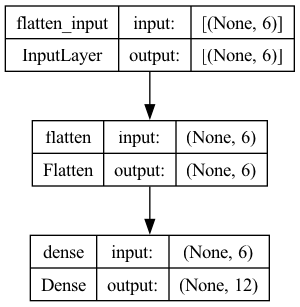

In [14]:
# modelling (다중 분류)

print ("records shape : ", df.iloc[0].shape)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(6, )), 
    keras.layers.Dense(12, activation='softmax')
])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [15]:
# compile

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [16]:
# fit
# early stopping callback을 통하여 overfitting 방지

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, 
                                                 restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=100, 
                    validation_data=(X_val_scaled, y_val),
                   callbacks=[early_stopping_cb], batch_size=128, 
                    verbose=True)

print (history.history)

Epoch 1/100
32307/32307 [==============================] - 33s 997us/step - loss: 1.0925 - accuracy: 0.6550 - val_loss: 1.0641 - val_accuracy: 0.6605
Epoch 2/100
32307/32307 [==============================] - 32s 996us/step - loss: 1.0642 - accuracy: 0.6609 - val_loss: 1.0641 - val_accuracy: 0.6604
Epoch 3/100
32307/32307 [==============================] - 30s 936us/step - loss: 1.0642 - accuracy: 0.6609 - val_loss: 1.0641 - val_accuracy: 0.6625
Epoch 4/100
32307/32307 [==============================] - 27s 834us/step - loss: 1.0642 - accuracy: 0.6609 - val_loss: 1.0640 - val_accuracy: 0.6596
Epoch 5/100
32307/32307 [==============================] - 29s 901us/step - loss: 1.0642 - accuracy: 0.6609 - val_loss: 1.0642 - val_accuracy: 0.6614
Epoch 6/100
32307/32307 [==============================] - 32s 990us/step - loss: 1.0642 - accuracy: 0.6609 - val_loss: 1.0641 - val_accuracy: 0.6619
Epoch 7/100
32307/32307 [==============================] - 28s 863us/step - loss: 1.0642 - accuracy:

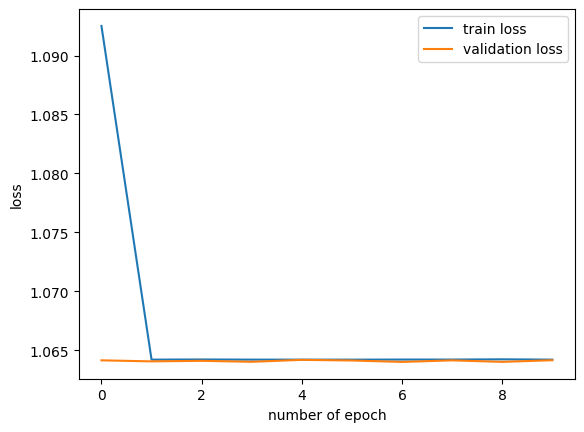

In [17]:
# loss 시각화

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

위 결과를 파악하면 다음과 같은 결과를 알 수 있다. 


- 일단은, accuracy가 약 0.6608를 유지하고 있다. 이는 ./ML_classification_HARTH에서 logistic regression 수행 시 cross-validation score인 0.6607과 거의 비슷하다.
- 왜 계속 accuracy가 유지되는지를 생각해보았을 때, 아래와 같은 근거를 찾을 수 있었다.
    - ./ML_classification_HARTH의 heatmap을 보았을 때 알 수 있듯이, 대부분의 feature correlation이 매우 저조한 것을 알 수 있다. 따라서 label에 미치는 영향이 그리 크지 않기에 epoch를 1~2번만 해도 특정 accuracy에 수렴할 수도 있다는 것.
    - 모델이 너무 단순해서 그럴지도 모른다.
    - feature가 너무 적어서 최적의 weight, bias를 금새 찾았을 지도 모른다.
- 그래도 train loss는 epoch 1에서 일정량 줄어들었으며, validation loss는 일정히 유지하고 있다.
    
PolynormialFeatures를 통하여 feature을 늘린 **X_train_poly_scaled**를 이용하여 다시 시도하여 본다.

In [ ]:
# 모델 재조정 및 재학습

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, )), 
    keras.layers.Dense(12, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(X_train_poly_scaled, y_train, epochs=100, 
                    validation_data=(X_val_poly_scaled, y_val), batch_size=128, 
                   callbacks=[early_stopping_cb], 
                    verbose=True)

print (history.history)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 28)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                348       
                                                                 
Total params: 348 (1.36 KB)
Trainable params: 348 (1.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
32307/32307 [==============================] - 37s 1ms/step - loss: 0.6957 - accuracy: 0.7892 - val_loss: 0.6296 - val_accuracy: 0.8106
Epoch 2/100
32307/32307 [==============================] - 34s 1ms/step - loss: 0.6210 - accuracy: 0.8142 - val_loss: 0.6155 - val_accuracy: 0.8170
Epoch 3/100
32307/32307 [==============================] - 28s 867us/step - loss: 0.6125 - accuracy: 0.8175 - val_loss: 0.61

In [ ]:
# loss 재시각화

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

**feature를 늘렸더니 전보다 더욱 accuracy가 높아졌으며, overfitting 또한 잘 제어하는 것을 확인 가능하다. 확인 가능하다. 추후엔 계속 poly set으로 학습을 진행한다.**

-------

### 3. DNN 
- hidden layer을 충분히 구성하여 신경망을 struction할 것임
    - 각 node의 activation은 relu 사용
    - epoch는 100으로 고정
    - records가 너무 많아 batch_size를 256으로 하여 학습한다.
- 아래와 같이 experiment할 예정이다.
    - optimizer는 **적응형 학습율 optimizer인 adam을 사용한다.**
    - validation loss 감소를 위하여 **dropout 층을 추가 후, callback으로 early stopping을 도입**한다.
        - patiences는 3로 한다.
    - **overfitting을 막기 위해 Dropout 층을 배치**한다.

In [ ]:
# modelling DNN
# 여기서는 feature를 늘린 X_train_poly_scaled를 사용한다.

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, )), 
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(12, activation='softmax')
])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# compile

adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics='accuracy')

In [ ]:
# callback 설정 및 fit

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, 
                                                 restore_best_weights=True)

history = model.fit(X_train_poly_scaled, y_train, epochs=100, 
                    validation_data=(X_val_poly_scaled, y_val), batch_size=256, 
                    callbacks=early_stopping_cb, verbose=True)

In [ ]:
# history 그리고 loss 시각화

print (history.history)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

In [ ]:
# evaluate

model.evaluate(X_val_poly_scaled, y_val)

In [ ]:
# confusion matrix 및 report
# validation dataset과 test dataset을 따로 report 및 matrix drawing

from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = model.predict(X_val_poly_scaled)
y_test_pred = model.predict(X_test_poly_scaled)

y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

############

cm_val = confusion_matrix(y_val, y_val_pred_classes)
print ("- validation data confusion matrix -\n")
print (cm_val)

print ('\n --------------- \n')

cm_test = confusion_matrix(y_test, y_test_pred_classes)
print ("- test data confusion matrix -\n")
print (cm_test)

print ('\n --------------- \n')

cr_val = classification_report(y_val, y_val_pred_classes)
print ("- validation data report of classification -\n")
print (cr_val)

print ('\n --------------- \n')

cr_test = classification_report(y_test, y_test_pred_classes)
print ("- test data report of classification -\n")
print (cr_test)

print ('\n --------------- \n')

-------

### 4.  CNN (1D)
- convolution을 통하여 중요한 feature만 도드라지게 하여 학습을 진행한다.
- 아래와 같이 dataset을 구성한다.
    - tensor로 전환하여 Conv1D layer로 convolution을 시행할 수 있을 것 같다. 아래와 같이 전환한다.
        - 배치 크기 : row 갯수 (sample의 수)
        - 길이 : feature 수 (col 수)
        - 채널 : 1 (단일 채널)
    - 전환 후 CNN 1d를 적용하여 main feature extraction 후 pooling을 진행한다.
    - Conv, pooling을 2번 반복 후 dense layer를 두어 regression한다.
        - 중간에 dropout 층을 배치하여 overfitting을 막고 학습에 신중하도록 한다.
- 여기서는 poly set 대신 normal set을 사용하겠다.


In [ ]:
# X_train_scaled, X_test_scaled, X_val_scaled 데이터를 3차원 tensor로 전환한다.

X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], 
                                           X_train_scaled.shape[1], 
                                           1))

X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], 
                                         X_test_scaled.shape[1], 
                                         1))

X_val_cnn = X_val_scaled.reshape((X_val_scaled.shape[0], 
                                       X_val_scaled.shape[1], 
                                       1))

In [ ]:
# shape 확인

X_train_cnn.shape, X_test_cnn.shape, X_val_cnn.shape

In [ ]:
# modelling (functional API 방식)

# 입력 레이어
input_layer = keras.Input(shape=(X_train_scaled.shape[1], 1))

# 첫 번째 Conv1D 레이어 + MaxPooling1D + Dropout
conv_1 = keras.layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_layer)
pooling_1 = keras.layers.MaxPooling1D(2)(conv_1)
dropout_1 = keras.layers.Dropout(0.4)(pooling_1)

# 두 번째 Conv1D 레이어 + MaxPooling1D + Dropout
conv_2 = keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(dropout_1)
pooling_2 = keras.layers.MaxPooling1D(2)(conv_2)
dropout_2 = keras.layers.Dropout(0.4)(pooling_2)

# Flatten 레이어
flatten = keras.layers.Flatten()(dropout_2)

# 첫 번째 Dense 레이어 + Batch Normalization + Dropout
dense_1 = keras.layers.Dense(32, activation='relu')(flatten)
batchnorm_1 = keras.layers.BatchNormalization()(dense_1)
dropout_3 = keras.layers.Dropout(0.3)(batchnorm_1)

# 두 번째 Dense 레이어
dense_2 = keras.layers.Dense(16, activation='relu')(dropout_3)

# 출력 레이어
output_layer = keras.layers.Dense(12, activation='softmax')(dense_2)

# model = keras.Model(
#     input_layer,
#     conv_1,
#     pooling_1,
#     conv_2,
#     pooling_2,
#     flatten,
#     dense_1,
#     dropout_1,
#     dense_2,
#     dropout_2,
#     dense_3,
#     output_layer
# )

model = keras.Model(inputs=input_layer, outputs=output_layer)

model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

In [ ]:
# compile

adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile (optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fit

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, 
                                                restore_best_weights=True)

history = model.fit(X_train_cnn, y_train, epochs=100, 
                    validation_data=(X_val_cnn, y_val), batch_size=512, 
                    callbacks=early_stopping_cb, 
                    verbose=True)

In [ ]:
# history 그리고 loss 시각화

print (history.history)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

In [ ]:
# evaluate

model.evaluate(X_val_cnn, y_val)

In [ ]:
# confusion matrix 및 report
# validation dataset과 test dataset을 따로 report 및 matrix drawing

from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = model.predict(X_val_cnn)
y_test_pred = model.predict(X_test_cnn)

y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

############

cm_val = confusion_matrix(y_val, y_val_pred_classes)
print ("- validation data confusion matrix -\n")
print (cm_val)

print ('\n --------------- \n')

cm_test = confusion_matrix(y_test, y_test_pred_classes)
print ("- test data confusion matrix -\n")
print (cm_test)

print ('\n --------------- \n')

cr_val = classification_report(y_val, y_val_pred_classes)
print ("- validation data report of classification -\n")
print (cr_val)

print ('\n --------------- \n')

cr_test = classification_report(y_test, y_test_pred_classes)
print ("- test data report of classification -\n")
print (cr_test)

print ('\n --------------- \n')

하지만, 위 결과를 잘 생각해보자. **CNN을 진행 시에 split_sequence로 순환형 데이터를 만들지 않고, 단지 df에서 reshape한 형태로만 학습을 진행했다.** 이는 그저 **DNN과 다름이 없을 뿐**이니, split_sequence 함수를 사용하여 데이터를 순환형으로 만든 후에 다시 학습을 진행한다. split_sequence를 아래와 같이 정의하자.

In [ ]:
def split_sequence (sequences, n_steps) :
    X, y = [], [] 
    
    for i in range(len(sequences)) :
        end_ix = i + n_steps
        if end_ix > len(sequences)-1 :
            break
            
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix, -1]
        
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [ ]:
# sequential data로 변경 (여기서의 타임 스텝은 300으로)

n_steps = 300

X_train_seq, y_train_seq = split_sequence (np.column_stack((X_train_scaled, y_train)), n_steps)
X_test_seq, y_test_seq = split_sequence (np.column_stack((X_test_scaled, y_test)), n_steps)
X_val_seq, y_val_seq = split_sequence (np.column_stack((X_val_scaled, y_val)), n_steps)

In [ ]:
# 다시 modelling

# 입력 레이어
input_layer = keras.Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))

# 첫 번째 Conv1D 레이어 + MaxPooling1D + Dropout
conv_1 = keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
pooling_1 = keras.layers.MaxPooling1D(2)(conv_1)
dropout_1 = keras.layers.Dropout(0.4)(pooling_1)

# 두 번째 Conv1D 레이어 + MaxPooling1D + Dropout
conv_2 = keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(dropout_1)
pooling_2 = keras.layers.MaxPooling1D(2)(conv_2)
dropout_2 = keras.layers.Dropout(0.4)(pooling_2)

# Flatten 레이어
flatten = keras.layers.Flatten()(dropout_2)

# 첫 번째 Dense 레이어 + Batch Normalization + Dropout
dense_1 = keras.layers.Dense(32, activation='relu')(flatten)
batchnorm_1 = keras.layers.BatchNormalization()(dense_1)
dropout_3 = keras.layers.Dropout(0.3)(batchnorm_1)

# 두 번째 Dense 레이어
dense_2 = keras.layers.Dense(16, activation='relu')(dropout_3)

# 출력 레이어
output_layer = keras.layers.Dense(12, activation='softmax')(dense_2)

model = keras.Model(inputs=input_layer, outputs=output_layer)

model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True)

In [ ]:
# compile

adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile (optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fit

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, 
                                                restore_best_weights=True)

history = model.fit(X_train_seq, y_train_seq, epochs=100, 
                    validation_data=(X_val_seq, y_val_seq), batch_size=64, 
                    callbacks=early_stopping_cb, 
                    verbose=True)

In [ ]:
# history 그리고 loss 시각화

print (history.history)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

In [ ]:
# evaluate

model.evaluate(X_val_seq, y_val_seq)

In [ ]:
# confusion matrix 및 report
# validation dataset과 test dataset을 따로 report 및 matrix drawing

from sklearn.metrics import classification_report, confusion_matrix

y_val_pred = model.predict(X_val_seq)
y_test_pred = model.predict(X_test_seq)

y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

############

cm_val = confusion_matrix(y_val, y_val_pred_classes)
print ("- validation data confusion matrix -\n")
print (cm_val)

print ('\n --------------- \n')

cm_test = confusion_matrix(y_test, y_test_pred_classes)
print ("- test data confusion matrix -\n")
print (cm_test)

print ('\n --------------- \n')

cr_val = classification_report(y_val, y_val_pred_classes)
print ("- validation data report of classification -\n")
print (cr_val)

print ('\n --------------- \n')

cr_test = classification_report(y_test, y_test_pred_classes)
print ("- test data report of classification -\n")
print (cr_test)

print ('\n --------------- \n')

-------

### 5.  U-net

- U-Net은 원래 이미지 분할을 위해 설계된 합성곱 신경망(CNN)이지만, 시계열 데이터와 같은 데이터에도 적용할 수 있다.
- X_train_scaled를 conv1D에 대입 가능한 3차원 데이터로 reshape 후에 대입한다.
- **encoder** 
    - input의 important feature를 캡처하기 위해 여러 개의 합성곱 층과 맥스풀링 층으로 구성됨
    - 이 과정에서 입력 데이터는 다운샘플링되며, 특징 맵의 크기가 점점 줄어듬
    - 예시
      ```python
      conv_1 = keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(input_layer)
      pooling_1 = keras.layers.MaxPooling1D(2)(conv_1)
      dropout_1 = keras.layers.Dropout(0.3)(pooling_1)

      conv_2 = keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(dropout_1)
      pooling_2 = keras.layers.MaxPooling1D(2)(conv_2)
      dropout_2 = keras.layers.Dropout(0.3)(pooling_2)
      ```

- **decoder**
    - 이 경로는 업샘플링과 합성곱 층을 통해 원본 데이터의 해상도를 복원함
    - 수축 경로에서 얻은 특징을 결합하여 최종 출력 이미지를 생성함.
    - 예시
      ```python
      conv_3 = keras.layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(dropout_2)
      upsampling_1 = keras.layers.UpSampling1D(2)(conv_3)
      ```
      
<br>

<img src='https://miro.medium.com/v2/resize:fit:1358/0*IYsBMfBEIQGiY88r.png' width='500px'>
<img src='https://i.imgur.com/2MUbGYf.png' width='500px'>

**U-net을 정확히 이해하기 위해서 위 U-net 이미지 figure만 보고 직접 modeling하였다. 그로 인하여 거의 3일이 넘는 시간 동안 U-net modeling에만 시간을 투자했다. 아래는 그 시행착오의 흔적이다.**

- 기존에는 bottleneck이 1024개의 노드를 지니게 만들었으나, ETA가 기하급수적으로 늘어나 감당할 수 없음을 판단 후, 128개의 노드를 지니게 재구성하였다.
- 구현 도중, 다음과 같은 문제에 봉착하였다.
    - **문제 1 : U-Net 2D 모델을 1D로 변형**
      - **문제** : 원래는 2D로 구현하였으나, 2D로 reshape하여 U-net을 구성하면 pooling layer가 음수 차원으로 도달하는 문제가 있었다.
      - **해결 방법** : 2D 레이어를 1D 레이어로 변경하고, 커널 크기와 풀링 사이즈를 1D에 맞게 조정하여 unet_1d 모델을 만들었다.

    - **문제 2 : 입력 데이터의 크기 문제**
      - **문제** : 1D 데이터이지만 `height = 1`과 `width`를 맞춰서 `reshape`해야 하였다.
      - **해결 방법** : 데이터를 `(height, width, channels)` 형태로 `reshape`하여 모델에 맞게 조정하였다. 따라서 input data의 형태는 (records 갯수, feature 갯수, 1)이다.

    - **문제 3 : MaxPooling1D에서 음수 차원 크기 오류**
      - **문제** : `MaxPooling1D` 연산이 데이터의 차원을 너무 작게 만들어서 오류가 발생하였다.
      - **해결 방법** : 새로운 시도를 하였다. MaxPooling1D를 사용하는 이유는 중요 feature를 뽑아내기 위함인데, 이를 conv1D의 stride를 이용하여 feature map의 크기를 줄이도록 하였다.

    - **문제 4 : 디코더와 인코더의 비대칭성**
      - **문제** : 디코더 부분이 인코더와 대칭이 되지 않았다. concatenate할 때 size 문제 때문에 제대로 compile이 되지 않는 문제가 발생하였다.
      - **해결 방법** : 각 디코더 단계에서 인코더의 출력과 맞춰서 업샘플링 및 `concatenate`의 오류를 해결하기 위하여 zero padding layer와 cropping layer을 추가하여 tensor의 크기를 맞추었다.

In [ ]:
# reshape

X_train_unet = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_unet = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
X_val_unet = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))

In [ ]:
# shape 확인

X_train_unet.shape, X_test_unet.shape, X_val_unet.shape

이전 unet_1d_custom 함수의 구성은 encoder에서부터 node의 수가 증가한 후, decoder에서 다시 node의 수가 대칭적으로 감소하는 형태였으나, 이는 U-net의 일반적인 형태가 아님을 인지한 뒤에 다시 수정한다. 수정하기 전의 model figure은 아래와 같다.

<br>

<img src='./model_prev.png' width='200px'>

In [ ]:
'''
    이전 모델 수정
    - 이전 모델은 encoder-bottleneck의 노드 수가 증가, bottleneck-decoder의 노드 수가 감소 (대칭) <-- 잘못된 형태
'''

from tensorflow.keras import layers, models

def unet_1d_custom(input_shape, num_classes) :
    inputs = layers.Input(shape=input_shape)
    
    # 인코더
    c1 = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(c1)
    p1 = layers.Conv1D(128, kernel_size=3, strides=2, activation='relu', padding='same')(c1)  # 다운샘플링

    c2 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(p1)
    c2 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(c2)
    p2 = layers.Conv1D(64, kernel_size=3, strides=2, activation='relu', padding='same')(c2)  # 다운샘플링

    c3 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(p2)
    c3 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(c3)
    p3 = layers.Conv1D(32, kernel_size=3, strides=2, activation='relu', padding='same')(c3)  # 다운샘플링

    # 보틀넥
    b1 = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same')(p3)
    b1 = layers.Conv1D(16, kernel_size=3, activation='relu', padding='same')(b1)

    # 디코더
    u3 = layers.Conv1DTranspose(32, kernel_size=2, strides=2, padding='same')(b1)  # 업샘플링
    
    if u3.shape[1] != c3.shape[1] :
        diff = c3.shape[1] - u3.shape[1]
        
        if diff > 0 :
            u3 = layers.ZeroPadding1D(padding=(0, diff))(u3)
            
        else :
            u3 = layers.Cropping1D(cropping=(0, -diff))(u3)
            
    u3 = layers.concatenate([u3, c3], axis=-1)  # 인코더와 연결
    c7 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(u3)
    c7 = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(c7)

    u4 = layers.Conv1DTranspose(64, kernel_size=2, strides=2, padding='same')(c7)  # 업샘플링
    if u4.shape[1] != c2.shape[1] :
        diff = c2.shape[1] - u4.shape[1]
        
        if diff > 0 :
            u4 = layers.ZeroPadding1D(padding=(0, diff))(u4)
            
        else :
            u4 = layers.Cropping1D(cropping=(0, -diff))(u4)
            
    u4 = layers.concatenate([u4, c2], axis=-1)  # 인코더와 연결
    c8 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(u4)
    c8 = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(c8)

    u5 = layers.Conv1DTranspose(128, kernel_size=2, strides=2, padding='same')(c8)  # 업샘플링
    if u5.shape[1] != c1.shape[1] :
        diff = c1.shape[1] - u5.shape[1]
        
        if diff > 0 :
            u5 = layers.ZeroPadding1D(padding=(0, diff))(u5)
            
        else :
            u5 = layers.Cropping1D(cropping=(0, -diff))(u5)
            
    u5 = layers.concatenate([u5, c1], axis=-1)  # 인코더와 연결
    c9 = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(u5)
    c9 = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(c9)

    # 출력층 
    outputs = layers.Conv1D(num_classes, kernel_size=1, activation='softmax')(c9)
    outputs = layers.Flatten()(outputs)
    outputs = layers.Dense(num_classes, activation='softmax')(outputs)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    
    return model

# 모델 생성
input_shape = (6, 1)  # 길이 6, 채널 1인 입력 데이터
num_classes = 12
model = unet_1d_custom(input_shape=input_shape, num_classes=num_classes)

model.summary()
keras.utils.plot_model(model, show_dtype=True,
                      show_layer_activations=True,
                      show_layer_names=True,
                      show_shapes=True,
                      show_trainable=True)

In [ ]:
# compile

from tensorflow.keras.losses import SparseCategoricalCrossentropy

adam = keras.optimizers.Adam()
model.compile(optimizer=adam, 
              loss=SparseCategoricalCrossentropy(from_logits=False), 
              metrics='accuracy')

In [ ]:
# fit

early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, 
                                                restore_best_weights=True)

history = model.fit(X_train_unet, y_train, epochs=100, 
                    validation_data=(X_val_unet, y_val), 
                    callbacks=early_stopping_cb, 
                    batch_size=512,
                    verbose=True)

In [ ]:
# history 그리고 loss 시각화

print (history.history)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('number of epoch')
plt.ylabel('loss')
plt.legend (['train loss', 'validation loss'])
plt.show() 

In [ ]:
# evaluate

model.evaluate(X_val_unet, y_val)

In [ ]:
# confusion matrix 및 report
# validation dataset과 test dataset을 따로 report 및 matrix drawing

y_val_pred = model.predict(X_val_unet)
y_test_pred = model.predict(X_test_unet)

y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

############

cm_val = confusion_matrix(y_val, y_val_pred_classes)
print ("- validation data confusion matrix -\n")
print (cm_val)

print ('\n --------------- \n')

cm_test = confusion_matrix(y_test, y_test_pred_classes)
print ("- test data confusion matrix -\n")
print (cm_test)

print ('\n --------------- \n')

cr_val = classification_report(y_val, y_val_pred_classes)
print ("- validation data report of classification -\n")
print (cr_val)

print ('\n --------------- \n')

cr_test = classification_report(y_test, y_test_pred_classes)
print ("- test data report of classification -\n")
print (cr_test)

print ('\n --------------- \n')